<div class="alert alert-success">

## Instructions to students

If the assignment was fetched from the assignments tab, do not change the name of the assignment file(s).

### Code answers

In questions that require you to write code, there will be a code cell containing: 
    
<code># YOUR CODE HERE</code>
<br>
<code>raise NotImplementedError()</code>
    
When you are ready to write your answer, delete <code>raise NotImplementedError()</code> and write your code.

### Submitting your work
    
You should save your work before you submit ("Save" icon in top menu).
    
Before you submit, ensure that the notebook can be run from start to finish by pressing the "Restart & Run All" option in the "Kernel" menu above.
    
Once you are ready, go to the assignments tab on the Noteable landing page and click "Submit" on the relevant assignment.

</div>

**Question 7**: The code in the cell below has errors. There are errors preventing the code to run as intended. 

Your **task** is to find all mistakes, remove them, make the code function properly such that it presents a correct figure at the end. 

A brief text at the top of the code in comments explains what the code is meant to be doing. It is strongly recommended to start the exercise by copying the entire code to a separate python file and examine it in Spyder. 

**Note A**: Leave the function names unchanged. Some will be assumed in tests. Constant values as given are all correct.

**Note B**: This exercise involves random numbers hence every figure will look different. Getting a figure at all is already a success. Marking of figures is manual hence checks will be made to see whether a correct figure emerges even if that means running your code several times due to the built in randomness.

**Note C**: The number of pulses produced follows the Poisson distribution and a single pulse is a valid outcome for the sequence. However, checking that your code works correctly, re-run until you see an example with Npulses>1 fully analysed. Only then can you be certain that all mistakes have been removed.

**Note D**: There are two faults in the code before(!) the `analysis()` function and three further faults after(!) that function. All other programming faults can be found inside that function.

**Note E**: Copy your final solution back into the cell below so that the tests can run.

+n pulses:  3
npe:  1
in filtered:  [51.5]
[ 10.00003388  50.03175075   2.00223578 149.90285976]


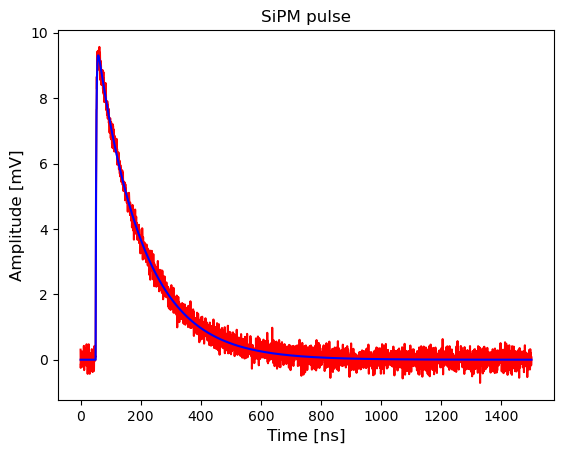

In [47]:
'''
SiPM single event modelling
(a) Make a pulse, always 50 ns after the start of the event.
(b) Randomly decide with the dark count rate how many
    additional pulses should be created.
(c) for more than zero, add additional pulses with random amplitude
    in discrete units of scale and random position in time
    according to exponential distribution and dark count rate.
(d) Analyse event: first filter with matched filter and find peaks.
(e) Use results on peak positions and number to fit all peaks, especially if there are more than one.
(f) Draw data and fit.
'''
# YOUR CODE HERE
import numpy as np 
import random
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit


def matchedFilter(data, template): # YR: no error in this function
    return np.correlate(data, template, mode = 'full')



def pulseSequence(t, *pos):
    total = np.zeros_like(t)
    for idx in range(0, len(pos),4): # superposition of pulses
        total += pulse(t, pos[idx], pos[idx+1], pos[idx+2], pos[idx+3])
    return total



def pulse(time, amplitude, start, rt, dt):
    singlepulse = np.exp(-(time - start) / rt) - np.exp(-(time - start) / dt)
    singlepulse[np.where(time < start)] = 0.0 # not defined before onset time, set 0
    return -amplitude * singlepulse



def makeTemplate(rt, dt):
    timevalues = np.linspace(0, 50, 101) # 0.05 mus, 0.5 unit step size
    scale = 1.0   # some scale factor giving reasonable values
    onset = 0.0    # pulse start [ns]
    dummy = pulse(timevalues, scale, onset, rt, dt)
    template = dummy / np.trapz(dummy, x = timevalues) # normalized
    return timevalues, template


def dataProduction(time, cfg):
    amp = cfg[0]   # some scale factor giving reasonable values
    start = cfg[1]    # pulse start [ns]
    rtime = cfg[2]   # realistic rise time
    dtime = cfg[3] # realistic decay time
    noiselevel = cfg[4] # noise level scale
    dcr = cfg[5] # [1/ns] => 2 MHz

    framestop = time[-1] # final time bin

    # There is always the default pulse, see below.
    # These Npulses add to the default!
    Npulses = np.random.poisson(framestop * dcr)
    while Npulses<1:  # want at least 2 pulses to test analysis
        Npulses = np.random.poisson(framestop * dcr)
    print ('+n pulses: ', Npulses)

    pp = pulse(time, amp, start, rtime, dtime)
    noisy = np.random.normal(pp, scale = noiselevel)
    frame = noisy # first triggered pulse at onset
    npe = 1 # certainty to have one additional pulse, same amplitude
    for _ in range(Npulses): # additional pulses
        print('npe: ', npe)
        pretrigger = start
        triggertime = random.expovariate(dcr) # rate parameter
        start = pretrigger + triggertime + 100 # for fit safety
        if start > framestop-300:
            break
        if npe > 0:
            print('next onset: ', start)
            pp = pulse(time, npe * amp, start, rtime, dtime)
            frame += pp
        npe = np.random.poisson(1.0) # n photo electrons
    return frame

# YR: Most, not all, errors are in this function.
def analysis(tvalues, data, cfg):
    scale = cfg[0]   # some scale factor giving reasonable values
    rtime = cfg[2]   # realistic rise time
    dtime = cfg[3] # realistic decay time

    # prepare the analysis with the matched filter - get a template pulse
    time, tplt = makeTemplate(rtime, dtime)
    time -= time[-1]
    filtered = matchedFilter(data, tplt) # filter
    responsetime = np.concatenate((time[:-1], tvalues), axis=None)

    # search the filtered result for peaks in response
    peakfilt, _ = find_peaks(filtered,height = 5.0,distance = 6.0)
    print('in filtered: ', responsetime[peakfilt])

    # fit the pulse, try similar initial values to construction
    # and the identified peak number and positions
    if responsetime[peakfilt].size == 0:
        return None # failed peak finding
    init = []

    # construct the initial parameter array
    for val in responsetime[peakfilt]:
        init.append([scale, val, rtime, dtime])
    try:
        fitParams, _ = curve_fit(pulseSequence, tvalues, data,
                                 p0 = np.array(init))
        print(fitParams)
    except (RuntimeError, ValueError):
        fitParams = None # failed fit

    return fitParams


# Start main script
# make a pulse, consider times in nano seconds [ns]
# See note (A) on constant values.
timevalues = np.linspace(0, 1500, 3001) # 1.5 mus, 0.5 unit step size
scale = 10.0   # some scale factor giving reasonable values
risetime = 2.0   # realistic rise time
decaytime = 150.0 # realistic decay time
onset = 50.0    # pulse start [ns]
nlevel = 0.2  # noise level scale
darkCountRate = 0.002 # [1/ns] => 2 MHz
config = [scale, onset, risetime, decaytime, nlevel, darkCountRate]

# Data production first
res = dataProduction(timevalues, config)

# then analyse the event
bestfit = analysis(timevalues, res, config)

# finally plotting
plt.plot(timevalues, res, 'r-')
if bestfit is not None:
    plt.plot(timevalues, pulseSequence(timevalues, *bestfit), 'b-')
plt.title('SiPM pulse', size=12)
plt.xlabel('Time [ns]', size=12)
plt.ylabel('Amplitude [mV]', size=12)

plt.show()

Manual plot marking with feedback where appropriate.

In [ ]:
# Test cell, do not delete

In [ ]:
# Test analysis function, do not delete

In [ ]:
# Test analysis function, do not delete

### Tests - 5 marks; Plot - 3 marks